In [96]:
#import library
import numpy as np # linear algebra
import pandas as pd # data processing, example. CSV file
import datetime as dt

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for machine learning algo
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
df = pd.read_excel('drive//My Drive//machine learning//Online Retail.xlsx')

In [99]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [101]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [102]:
df = df.dropna(subset=['CustomerID'])
df.isnull().sum().sum()

0

In [103]:
df.duplicated().sum()

5225

In [104]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [105]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [106]:
df = df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df.describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [107]:
df.shape

(392692, 8)

# **Make Cohort Analysis**

**there are few labels we need to create before analysis**


*   **Invoice period**: A string representation of the year and month in a single transaction or invoice
*   **Cohort groupd**: A string representation of the year and month of a customer's first purchase
* **Cohort period/index**: An integer representation a customer's lifetime stage. It represents the number of months passes since the first purchase



In [108]:
def get_month(x): return dt.datetime(x.year, x.month, 1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [109]:
def get_month_int(dframe, column):
  year = dframe[column].dt.year
  month = dframe[column].dt.month
  day = dframe[column].dt.day
  return year, month, day

invoice_year, invoice_month, _ = get_month_int(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_month_int(df, 'CohortMonth')

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df['CohortIndex'] = year_diff*12 + month_diff + 1
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1


In [110]:
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Retention Rate**

In [111]:
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size, axis=0)
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


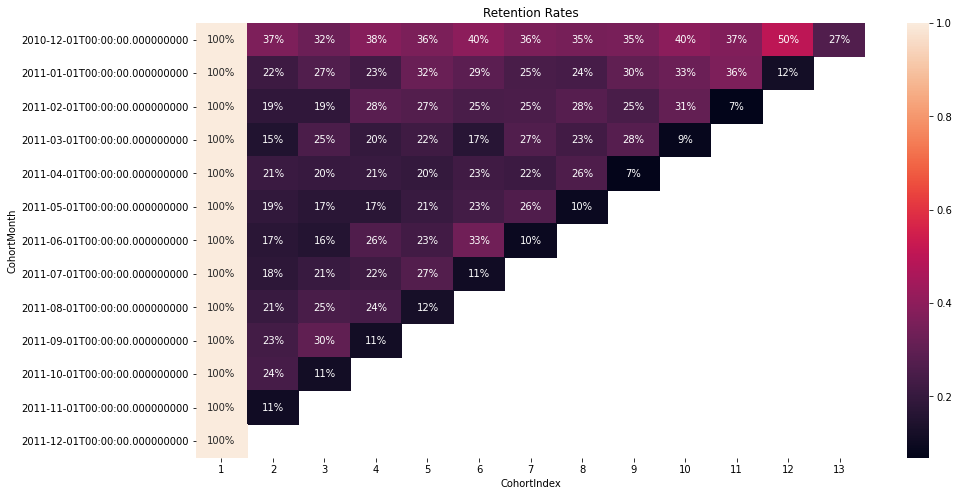

In [112]:
# build the heatmap
plt.figure(figsize=(15,8))
plt.title('Retention Rates')
sns.heatmap(data=retention, annot=True, fmt='.0%')
plt.show()

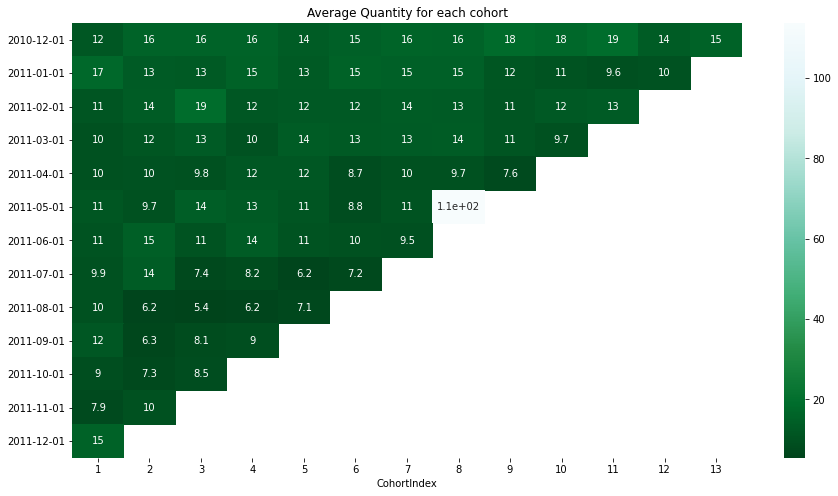

In [113]:
# average quantity for each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

# build the heatmap
plt.figure(figsize=(15,8))
plt.title('Average Quantity for each cohort')
sns.heatmap(data=average_quantity, annot=True, cmap="BuGn_r")
plt.show()

# **RFM Analysis**

**Process of calculating percentiles process(RFM method)**


*   Sort customers
*   Break customers into pre-defined number of groups of equal size
* Assign a label to each group



In [114]:
# add total sum column
df['TotalSum'] = df['UnitPrice'] * df['Quantity']

print('Min Invoice date: ', df.InvoiceDate.dt.date.min())
print('Max Invoice date: ', df.InvoiceDate.dt.date.max())

df.head()

Min Invoice date:  2010-12-01
Max Invoice date:  2011-12-09


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,20.34


In [115]:
# Last date of purchased
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [116]:
# Calculate RFM metrics
rfm = df.groupby(['CustomerID']).agg({ 'InvoiceDate': lambda x: (snapshot_date-x.max()).days, 'InvoiceNo': 'count', 'TotalSum': 'sum' })
#Function Lambda: it gives the number of days between hypothetical today and the last transaction

# Rename columns
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalSum': 'MonetaryValue'}, inplace=True)
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [117]:
# building RFM segments
r_labels = range(4,0,-1)
f_labels = range(1,5)
m_labels = range(1,5)

r_quantiles = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
f_quantiles = pd.qcut(rfm['Frequency'], q=4, labels=f_labels)
m_quantiles = pd.qcut(rfm['MonetaryValue'], q=4, labels=m_labels)
rfm = rfm.assign(R=r_quantiles, F=f_quantiles, M=m_quantiles)

# RFM score
def add_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])

rfm['RFM_segment'] = rfm.apply(add_rfm, axis=1)
rfm['RFM_score'] = rfm[['R', 'F', 'M']].sum(axis=1)
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,1.01.04.0,6
12347.0,2,182,4310.00,4,4,4,4.04.04.0,12
12348.0,75,31,1797.24,2,2,4,2.02.04.0,8
12349.0,19,73,1757.55,3,3,4,3.03.04.0,10
12350.0,310,17,334.40,1,1,2,1.01.02.0,4


**Largest RFM segments It is always the best practice to investigate the size of the segments before you use them for targeting or other business Application.**

In [118]:
rfm.groupby(['RFM_segment']).size().sort_values(ascending=False)

RFM_segment
4.04.04.0    450
1.01.01.0    381
3.04.04.0    217
1.02.02.0    206
2.01.01.0    179
            ... 
1.02.04.0      7
3.01.04.0      7
4.01.04.0      6
1.04.02.0      3
4.04.01.0      3
Length: 61, dtype: int64

**Filtering on RFM segment**

In [119]:
rfm[rfm['RFM_segment']=='222'].head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
CustomerID,,,,,,,,


**Summary metrics per RFM score**

In [120]:
rfm.groupby(['RFM_score']).agg({ 'Recency': 'mean','Frequency': 'mean','MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_score                                      
3           260.7       8.2         157.4   381
4           177.2      13.6         240.0   388
5           152.9      21.2         366.6   518
6            95.9      27.9         820.8   457
7            79.6      38.0         758.1   463
8            64.1      56.0         987.3   454
9            45.9      78.7        1795.1   414
10           32.4     110.5        2056.4   426
11           21.3     186.9        4062.0   387
12            7.2     367.8        9285.9   450

**Use RFM score to group into Gold, Silver and Bronze segments**

In [121]:
def segments(df):
  if df['RFM_score']>9:
    return 'Gold'
  elif (df['RFM_score']>5) and (df['RFM_score']<=9):
    return 'Silver'
  else:
    return 'Bronze'

rfm['General_segment'] = rfm.apply(segments, axis=1)
rfm.groupby(['General_segment']).agg({ 'Recency': 'mean','Frequency': 'mean','MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_segment                                      
Bronze            192.2      15.1         266.5  1287
Gold               20.1     225.6        5246.8  1263
Silver             72.0      49.4        1072.4  1788

# **Data Pre-processing for KMeans clustering**

**we must check some key kmeans assumptions before we implement our kmeans clustering mode**


*   symmetric distribution of variables(not skewed)
*   variables with same average values
* variables with same variance



In [122]:
rfm_rfm = rfm[['Recency', 'Frequency', 'MonetaryValue']]
rfm_rfm.describe()

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,92.536422,90.523744,2048.688081
std,100.014169,225.506968,8985.230220
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,306.482500
50%,51.000000,41.000000,668.570000
75%,142.000000,98.000000,1660.597500
max,374.000000,7676.000000,280206.020000


**For this table, mean and variance are not equal**

**solution: Scaling variables by using scaler from scikit-library**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

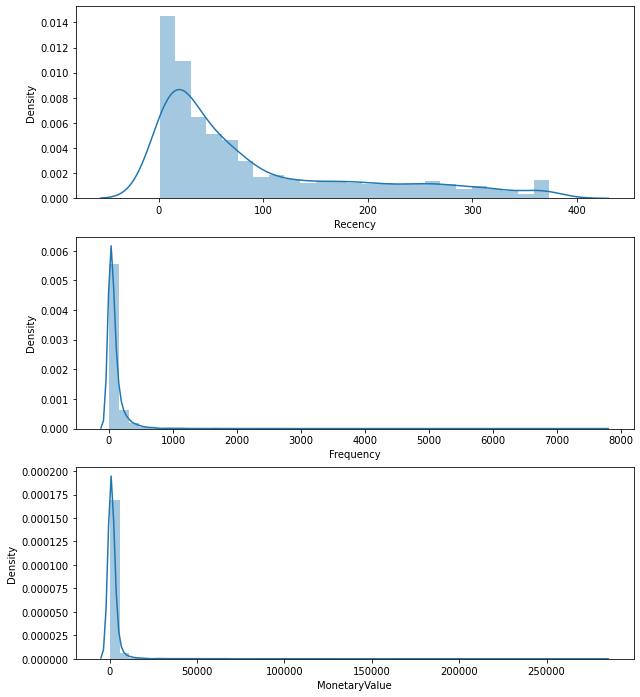

In [123]:
# Plot the distribution of RFM values
f, ax = plt.subplots(figsize=(10,12))
plt.subplot(3, 1, 1)
sns.distplot(rfm.Recency, label='Recency')
plt.subplot(3, 1, 2)
sns.distplot(rfm.Frequency, label='Frequency')
plt.subplot(3, 1, 3)
sns.distplot(rfm.MonetaryValue, label='Monetary Value')

**another problem: distribution of variables are not symmetric. it's skewed data**

**solution: logarithmic transformation(for positive values only) will manage it**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

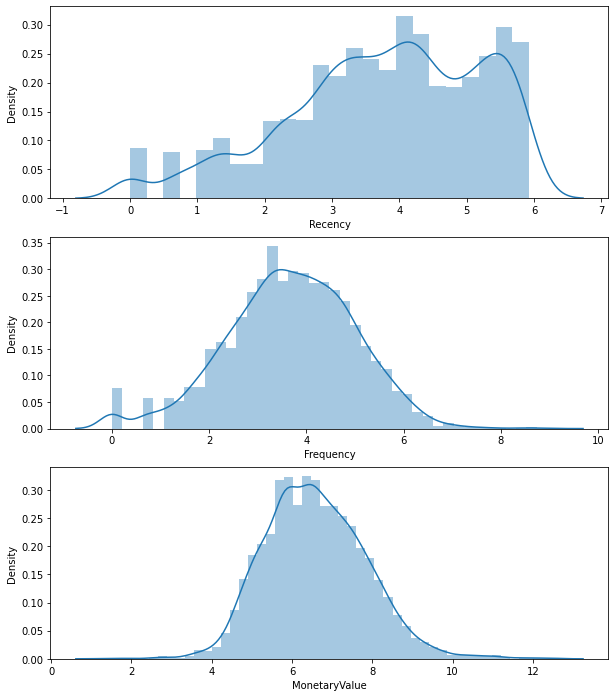

In [124]:
# unskew the data with log transformation
rfm_log = rfm[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis=1).round(3)
# rfm_log.describe()

# plot the distribution Of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1)
sns.distplot(rfm_log.Recency, label = 'Recency')
plt.subplot(3, 1, 2)
sns.distplot(rfm_log.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3)
sns.distplot(rfm_log.MonetaryValue, label = 'Monetary Value')

In [125]:
rfm_log

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,5.787,0.000,11.254
12347.0,0.693,5.204,8.369
12348.0,4.317,3.434,7.494
12349.0,2.944,4.290,7.472
12350.0,5.737,2.833,5.812
...,...,...,...
18280.0,5.628,2.303,5.196
18281.0,5.198,1.946,4.392
18282.0,2.079,2.485,5.182


# **Implementation of k-means clustering**

**data pre-processing**

In [126]:
# normalize the variables with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)

# store separately for clustering
rfm_normalized = scaler.transform(rfm_log)
rfm_normalized

array([[ 1.40998159, -2.77997064,  3.70023933],
       [-2.14657818,  1.16036535,  1.41349442],
       [ 0.38364809, -0.17983348,  0.71994094],
       ...,
       [-1.1788923 , -0.89839206, -1.11262551],
       [-1.66273524,  2.20299461,  0.82219054],
       [-0.00454336,  0.43650655,  0.73737886]])

**choosing the number of clusters, K**

**Elbow criterion method**


*   Plot the number of clusters against sum of squared errors(SSE) - sum of squared distances from every data point to their cluster center
*  Identify an 'elbow' in the plot
* Elbow - a point representing an optimal number of clusters



Text(0, 0.5, 'Inertia')

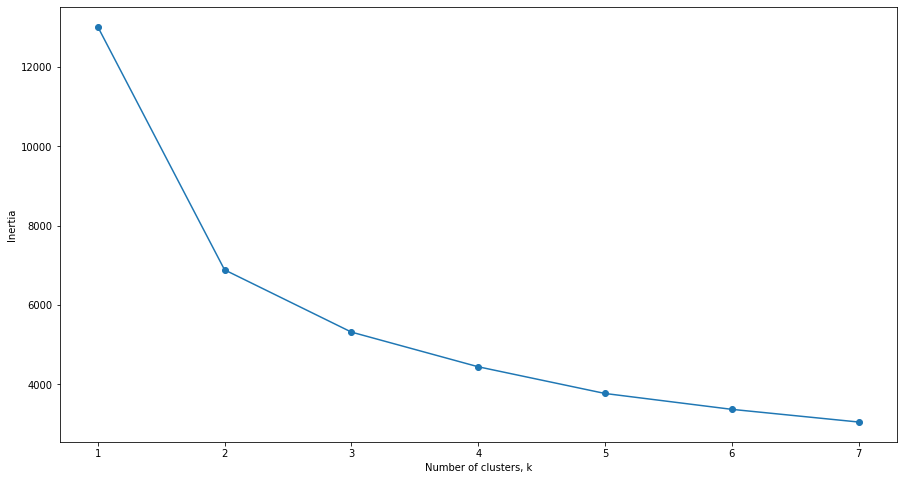

In [127]:
from sklearn.cluster import KMeans

inertias = []
for k in range(1,8):
  # create k-means cluster
  kc = KMeans(n_clusters=k, random_state=1)
  kc.fit(rfm_normalized)
  inertias.append(kc.inertia_)

# plot the graph to choose best elbow
f, ax = plt.subplots(figsize=(15,8))
plt.plot(range(1,8), inertias,'-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')


**Note: we choose best value, k = 3**

In [128]:
# clustering
kc = KMeans(n_clusters=3, random_state=1)
kc.fit(rfm_normalized)

# create cluster label column
cluster_labels = kc.labels_

rfm_rfm_k3 = rfm_rfm.assign(K_Cluster=cluster_labels)

# calculate average rfm values for each cluster
rfm_rfm_k3.groupby(['K_Cluster']).agg({ 'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue': ['mean', 'count'] }).round(0)

Recency Frequency MonetaryValue      
             mean      mean          mean count
K_Cluster                                      
0            13.0     260.0        6554.0   957
1            69.0      65.0        1167.0  1858
2           171.0      15.0         293.0  1523

**Snake plot to understand and compare segments**


* Market research technique
* Visual representation
* Need to first normalize data
* Plot each cluster's average normalized values



In [129]:
rfm_normalized = pd.DataFrame(rfm_normalized, index=rfm_rfm.index, columns=rfm_rfm.columns)
rfm_normalized['K_Cluster'] = kc.labels_
rfm_normalized['General_segment'] = rfm['General_segment']
rfm_normalized.reset_index(inplace=True)

rfm_melt = pd.melt(rfm_normalized, id_vars=['CustomerID', 'General_segment', 'K_Cluster'],
                   value_vars=['Recency', 'Frequency', 'MonetaryValue'], var_name='Metric', value_name='Value')
rfm_melt.head()

,CustomerID,General_segment,K_Cluster,Metric,Value
0,12346.0,Silver,1,Recency,1.409982
1,12347.0,Gold,0,Recency,-2.146578
2,12348.0,Silver,1,Recency,0.383648
3,12349.0,Gold,1,Recency,-0.574961
4,12350.0,Bronze,2,Recency,1.375072


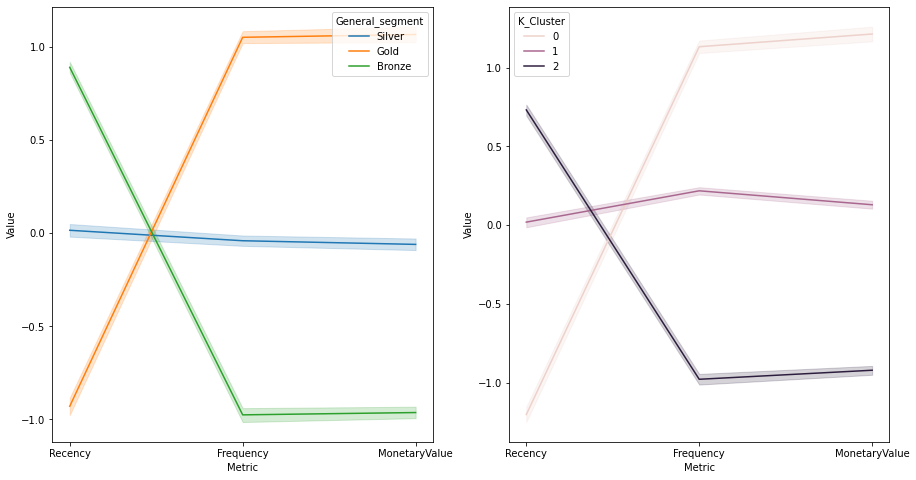

In [132]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
sns.lineplot(x='Metric', y='Value', hue='General_segment', data=rfm_melt, ax=ax1)

sns.lineplot(x='Metric', y='Value', hue='K_Cluster', data=rfm_melt, ax=ax2)

plt.show()

**Relative importance of segments**


* calculate average values of each cluster
* calculate average values of total population
* calculate importance score by dividing them



In [142]:
# for k-means cluster
cluster_avg = rfm_rfm_k3.groupby(['K_Cluster']).mean()
total_avg = rfm_rfm.mean()
relative_import = cluster_avg / total_avg - 1
relative_import.round(2)

,Recency,Frequency,MonetaryValue
K_Cluster,,,
0,-0.86,1.87,2.20
1,-0.25,-0.28,-0.43
2,0.85,-0.84,-0.86


In [150]:
# for rfm segment
cluster_avg = rfm.groupby(['General_segment']).mean().iloc[:,[0,1,2]]
relative_import2 = cluster_avg / total_avg - 1
relative_import2.round(2)

,Recency,Frequency,MonetaryValue
General_segment,,,
Bronze,1.08,-0.83,-0.87
Gold,-0.78,1.49,1.56
Silver,-0.22,-0.45,-0.48


# **Heatmap**

[Text(0.5, 1.0, 'Heatmap of RFM')]

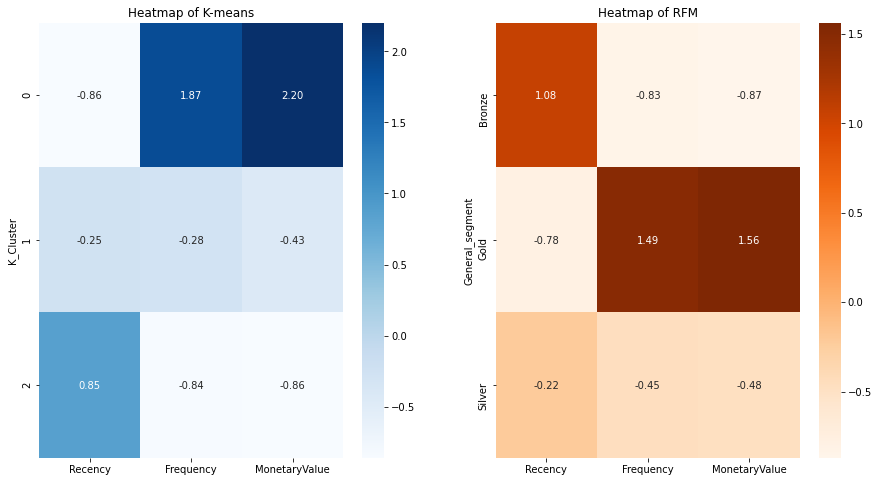

In [153]:
# heatmap with k-means
f, (ax1,ax2) = plt.subplots(1,2, figsize=(15,8))
sns.heatmap(data=relative_import, annot=True, fmt='.2f',cmap='Blues', ax=ax1)
ax1.set(title='Heatmap of K-means')

sns.heatmap(data=relative_import2, annot=True, fmt='.2f',cmap='Oranges', ax=ax2)
ax2.set(title='Heatmap of RFM')